In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Splitting the Data Into Train, Validation and Test Sets

Because the data is not seperated, it should be splitted into Train, Validation and Test sets. To do that, I used splitfolders library and splitted the data into Train, Validation and Test sets by 70%, 20% and 10% respectively.

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/data",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 4188 files [01:54, 36.58 files/s] 


## Data Transformation

Resizing and Normalizing methods are applied to all of the datasets but data augmentation techniques are only applied to Train set in order to richen the data so that the model possibly will yield more accurate results.

In [ ]:
#----------------------
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# -------- Transformation for the Whole Dataset for Visualization Purposes --------
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

## Loading the Data

In [ ]:
train = datasets.ImageFolder(root="/content/splitted_data/train",
                              transform=train_transform)

val = datasets.ImageFolder(root="/content/splitted_data/val",
                              transform=val_transform)

test = datasets.ImageFolder(root="/content/splitted_data/test",
                              transform=test_transform)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="/content/drive/MyDrive/data",
                              transform=data_transform)

In [ ]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 

Images per Class in TRAIN:
1    914
3    813
0    802
2    401
Name: count, dtype: int64 

Images per Class in VALIDATION:
1    261
3    232
0    229
2    114
Name: count, dtype: int64 

Images per Class in TEST:
1    131
3    117
0    115
2     59
Name: count, dtype: int64 



#### Plotting a few Images

Images plotted below did not undergo a data augmentation process. Therefore, they seem to be normal.

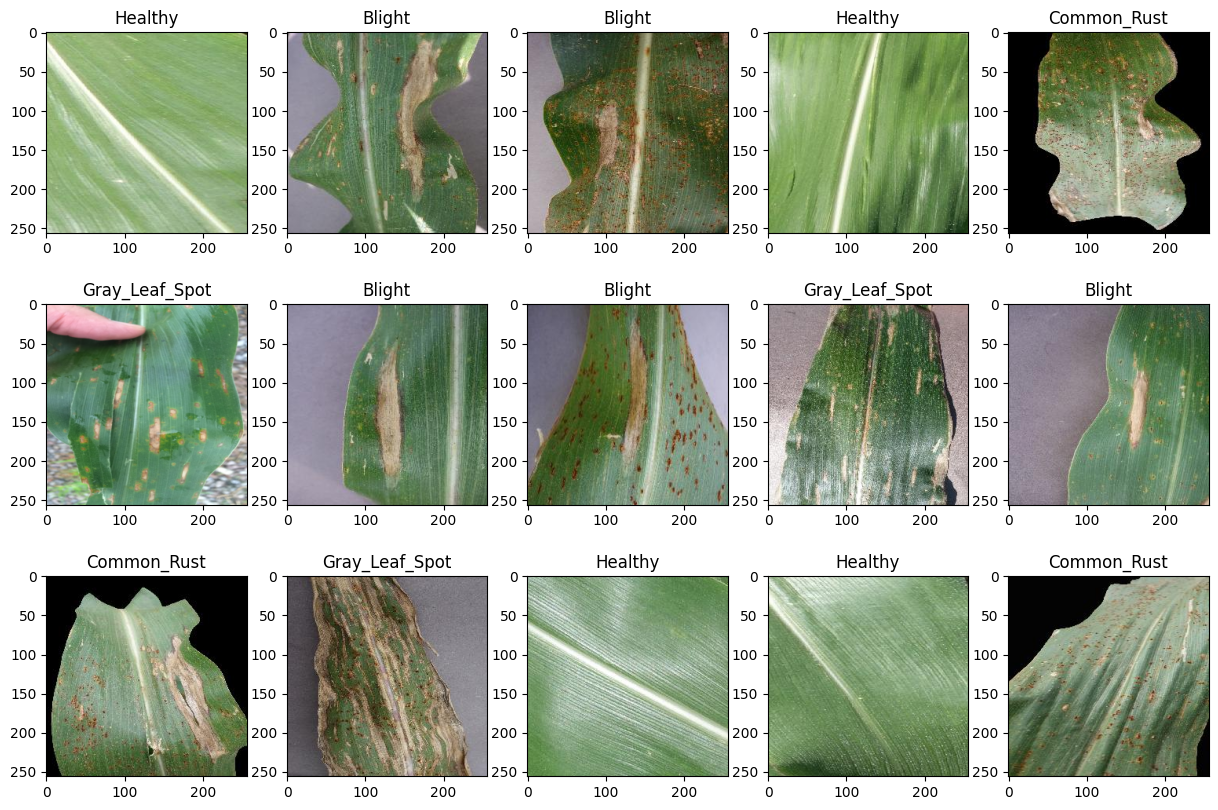

In [ ]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

### Plotting the Augmented Images
Because data augmentation methods are applied to Train set, it can be seen that images are blurred, horizontally and vertically flipped compared to the unaugmented images.

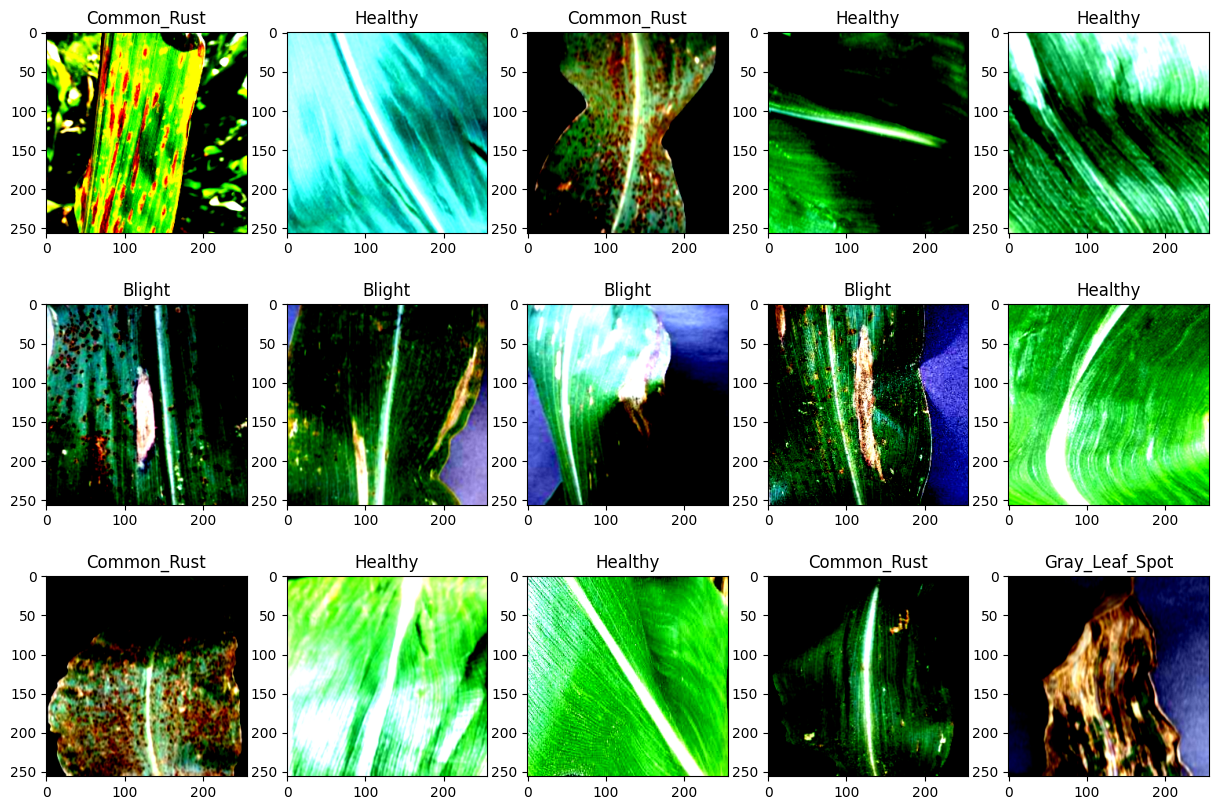

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(train))
    ax[i].imshow(train[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[train[sample][1]])

Before passing the data in a neural network, it should be batched and shuffled. Since test will not be used in training process, there is no need to shuffle it.

In [ ]:
train_dataloader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

When looking at the order of the data in relevant folder, it can be observed that images from class "Blight" comes first, "Common_Rust" second, "Gray_Leaf_Spot" third and "Healthy" last. An order as such can be problematic for the model to train unbiasedly. Let's take a batch and look at the labels to make sure that the data is shuffled.

In [ ]:
img, label = next(iter(train_dataloader))
print("Batch and Image Shape:", img.shape, "--> [batch_size, color_channels, height, width]")
print("\nLabels:", label)

Batch and Image Shape: torch.Size([32, 3, 256, 256]) --> [batch_size, color_channels, height, width]

Labels: tensor([0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 3, 1, 3, 0, 3, 3, 1, 3, 0, 1, 3,
        1, 3, 2, 3, 3, 3, 0, 3])


## Building the Deep Learning Model
Custom neural network architecture can be designed for this machine learning problem. With a neural network similar to the one below, an accuracy score around 80-84% is obtained. But for this project, I opt to apply Transfer Learning using ResNet18 architecture.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32), # in_features are selected based on the output that Flatten layer yields
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

## Transfer Learning - ResNet18

Transfer learning is a process of utilizing pre-trained machine learning models and applying them to a related task without need of models' learning from scratch for saving time and possibly better performance.

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Defining the Loss Function and Choosing an Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

## Defining Train and Test Functions

In [ ]:
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0


        # TRAINING LOOP
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)

        # VALIDATION LOOP
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)

                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()

        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)

        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model.pth")
            val_best_accuracy = val_accuracy

        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [ ]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=4)
    model = model.to(device)
    path = "model.pth"
    model.load_state_dict(torch.load(path))
    model.eval()

    running_accuracy = 0
    total = 0
    all_predictions = []

    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total

            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions) # returns a flattened array of batches of predictions

In [ ]:
EPOCHS = 20
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...
Completed Epoch:  1 - Training Accuracy: 84 - Validation Accuracy: 89 - Training Loss: 0.4152 - Validation Loss: 0.2461
Completed Epoch:  2 - Training Accuracy: 88 - Validation Accuracy: 90 - Training Loss: 0.2675 - Validation Loss: 0.2394
Completed Epoch:  3 - Training Accuracy: 92 - Validation Accuracy: 84 - Training Loss: 0.2017 - Validation Loss: 0.4068
Completed Epoch:  4 - Training Accuracy: 94 - Validation Accuracy: 95 - Training Loss: 0.1485 - Validation Loss: 0.1222
Completed Epoch:  5 - Training Accuracy: 93 - Validation Accuracy: 94 - Training Loss: 0.1503 - Validation Loss: 0.1597
Completed Epoch:  6 - Training Accuracy: 95 - Validation Accuracy: 89 - Training Loss: 0.1104 - Validation Loss: 0.3073
Completed Epoch:  7 - Training Accuracy: 96 - Validation Accuracy: 94 - Training Loss: 0.1082 - Validation Loss: 0.1460
Completed Epoch:  8 - Training Accuracy: 96 - Validation Accuracy: 95 - Training Loss: 0.0908 - Validation Loss: 0.1213
Completed Epoch:  9 -

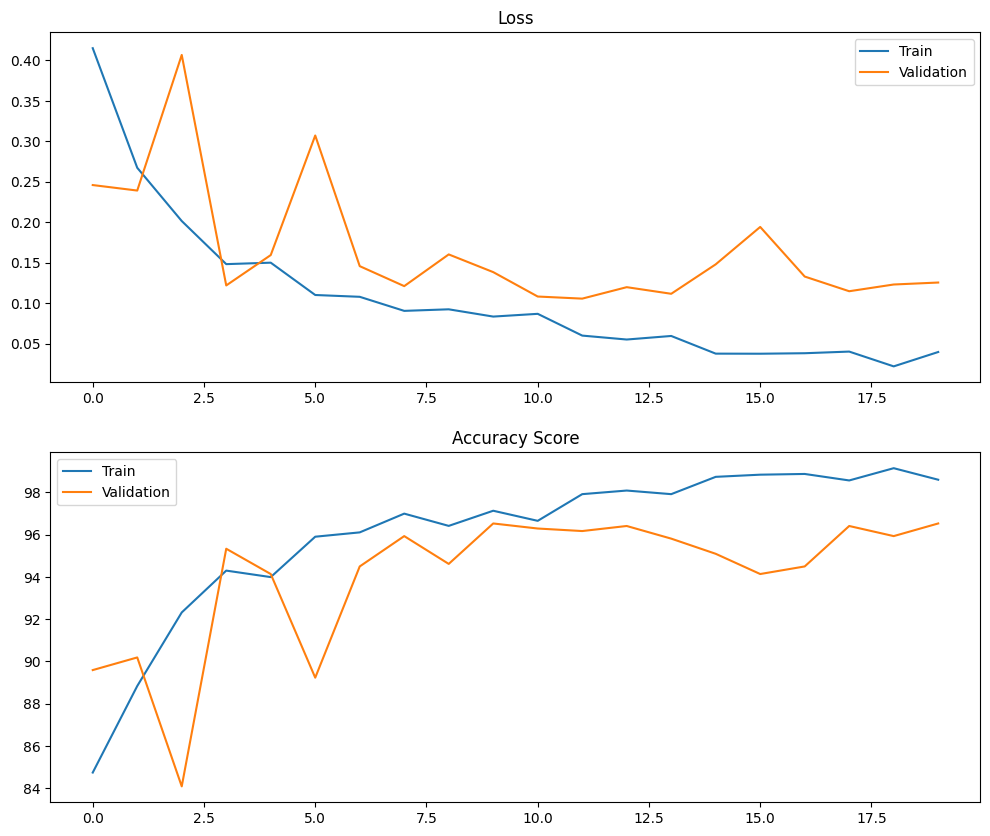

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

In [ ]:
print(classification_report(test.targets, all_preds))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       115
           1       0.98      0.99      0.99       131
           2       0.90      0.92      0.91        59
           3       1.00      1.00      1.00       117

    accuracy                           0.97       422
   macro avg       0.96      0.96      0.96       422
weighted avg       0.97      0.97      0.97       422



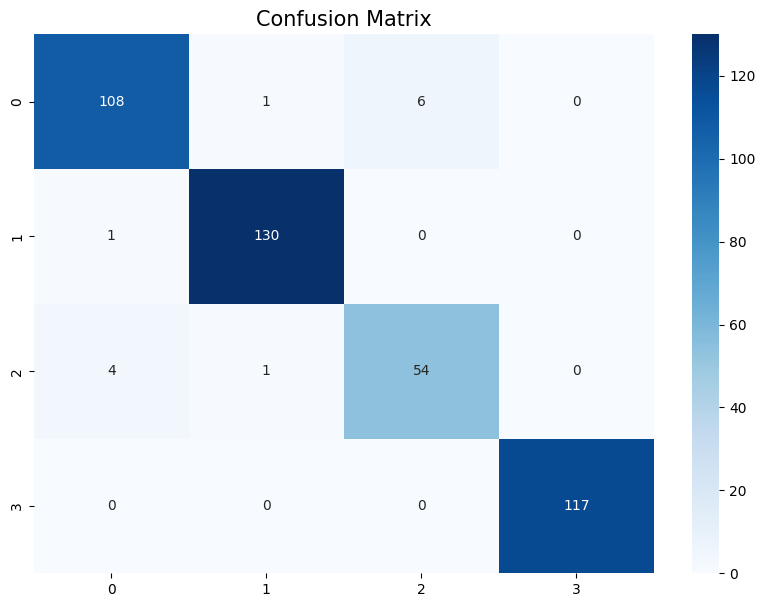

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

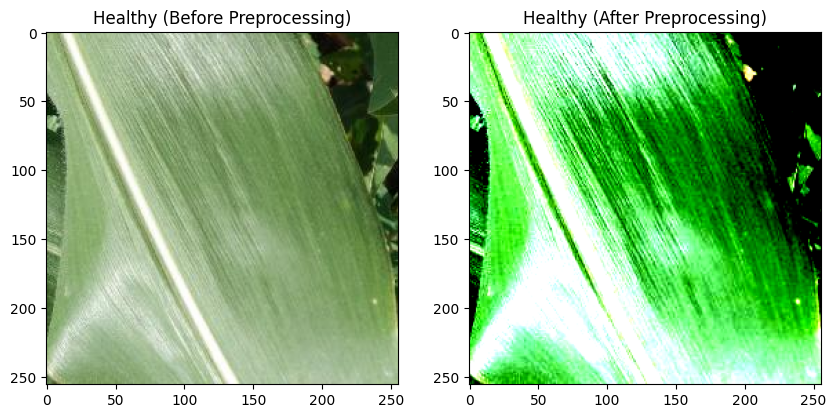

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()


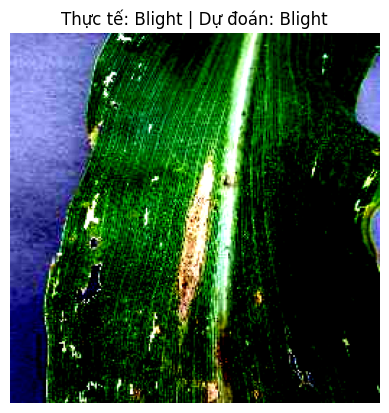

In [ ]:
import matplotlib.pyplot as plt

idx =110  # chỉ số ảnh bạn muốn xem

# Lấy ảnh và nhãn thật
image_tensor, true_label = test[idx]
image = image_tensor.to(device).unsqueeze(0)

# Dự đoán
model.eval()
with torch.no_grad():
    prediction = model(image)
    pred_class = torch.argmax(prediction, dim=1).item()

# Hiển thị ảnh gốc
plt.imshow(image_tensor.permute(1, 2, 0).cpu())  # chuyển từ [C,H,W] → [H,W,C]
plt.title(f"Thực tế: {labels_for_viz[true_label]} | Dự đoán: {labels_for_viz[pred_class]}")
plt.axis('off')
plt.show()





In [ ]:
single_prediction = int(torch.max(single_prediction, 1)[1])
print("Predicted Class:", labels_for_viz[single_prediction])

NameError: name 'single_prediction' is not defined

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Kiểm tra thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Thiết bị đang dùng:", device)

# Load đúng kiến trúc ResNet18 (giống lúc train)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 lớp bệnh: Blight, Common_Rust, Gray_Leaf_Spot, Healthy

# Load trọng số đã train
model.load_state_dict(torch.load("/content/model.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Đã load thành công mô hình ResNet18 đã train!")





Saving farmweek_v2023_n23004_a16f1.jpg to farmweek_v2023_n23004_a16f1.jpg
Đã chọn ảnh: farmweek_v2023_n23004_a16f1.jpg


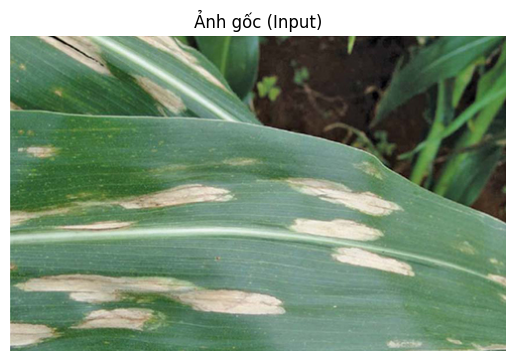

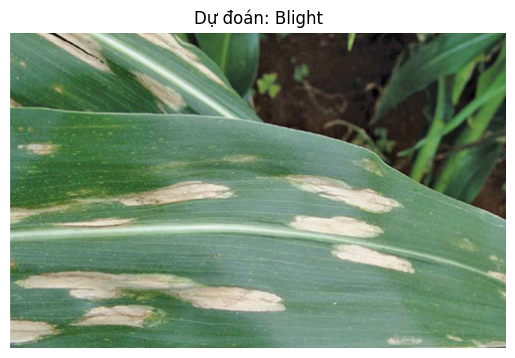

👉 Kết quả dự đoán: Blight

🔹 Xác suất dự đoán từng lớp:
Blight: 98.19%
Common_Rust: 0.00%
Gray_Leaf_Spot: 1.80%
Healthy: 0.00%


In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

# Chọn ảnh từ máy tính
uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print(f"Đã chọn ảnh: {img_path}")

# Đọc và hiển thị ảnh
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.title("Ảnh gốc (Input)")
plt.axis('off')
plt.show()

# Tiền xử lý (phải giống preprocessing khi train)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # kích thước chuẩn cho ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Chuẩn bị tensor
input_tensor = transform(img).unsqueeze(0).to(device)

# Dự đoán
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

labels_for_viz = {0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

plt.imshow(img)
plt.title(f"Dự đoán: {labels_for_viz[pred_class]}")
plt.axis('off')
plt.show()

print(f"👉 Kết quả dự đoán: {labels_for_viz[pred_class]}")
print("\n🔹 Xác suất dự đoán từng lớp:")
for i, label in labels_for_viz.items():
    print(f"{label}: {probs[0][i]*100:.2f}%")
